In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [122]:
df_values = pd.read_csv('Data/Nepal_Earthquake_train_values.csv', index_col='building_id')
df_labels = pd.read_csv('Data/Nepal_Earthquake_train_labels.csv', index_col='building_id')

### Merge the values dataframe with the labels dataframe

In [91]:
df = df_values.join(df_labels)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

### Target Distribution

In [105]:
df['damage_label'] = df.damage_grade.map(
    {1:'Low Damage', 2:'Medium Damage', 3:'Complete Destruction'})

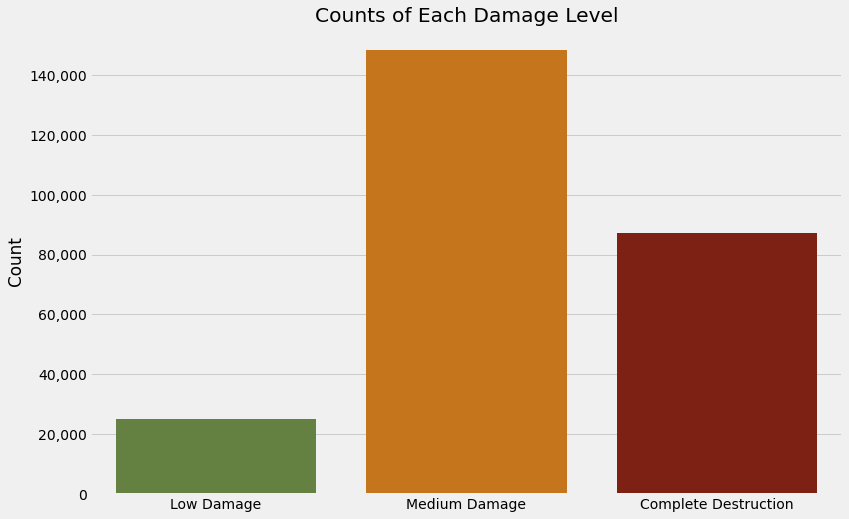

In [130]:
palette = {'Low Damage' : 'xkcd:moss green', 
           'Medium Damage': 'xkcd:pumpkin',
           'Complete Destruction': 'xkcd:brick red'}
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='damage_label', data=df, palette=palette, 
                   order=['Low Damage', 'Medium Damage', 'Complete Destruction'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('Counts of Each Damage Level');

### Create column categories

In [29]:
binary_cols = []
for col in df.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(df.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

### Categorical Columns

In [58]:
n_unique = 0
for col in cat_cols:
    n_unique += df[col].nunique()
    print(f"There are {df[col].nunique()} unique values in the feature '{col}'.")
    print(f"The values are {df[col].unique()}")
    print("--------------------------------")
print(f'There are {n_unique} total categorical values in the categorical columns.')

There are 3 unique values in the feature 'land_surface_condition'.
The values are ['t' 'o' 'n']
--------------------------------
There are 5 unique values in the feature 'foundation_type'.
The values are ['r' 'w' 'i' 'u' 'h']
--------------------------------
There are 3 unique values in the feature 'roof_type'.
The values are ['n' 'q' 'x']
--------------------------------
There are 5 unique values in the feature 'ground_floor_type'.
The values are ['f' 'x' 'v' 'z' 'm']
--------------------------------
There are 4 unique values in the feature 'other_floor_type'.
The values are ['q' 'x' 'j' 's']
--------------------------------
There are 4 unique values in the feature 'position'.
The values are ['t' 's' 'j' 'o']
--------------------------------
There are 10 unique values in the feature 'plan_configuration'.
The values are ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
--------------------------------
There are 4 unique values in the feature 'legal_ownership_status'.
The values are ['v' 'a' 'r

### Binary Columns

<ipython-input-55-bab438dd555b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(mean_binary_cols.index), rotation=90);


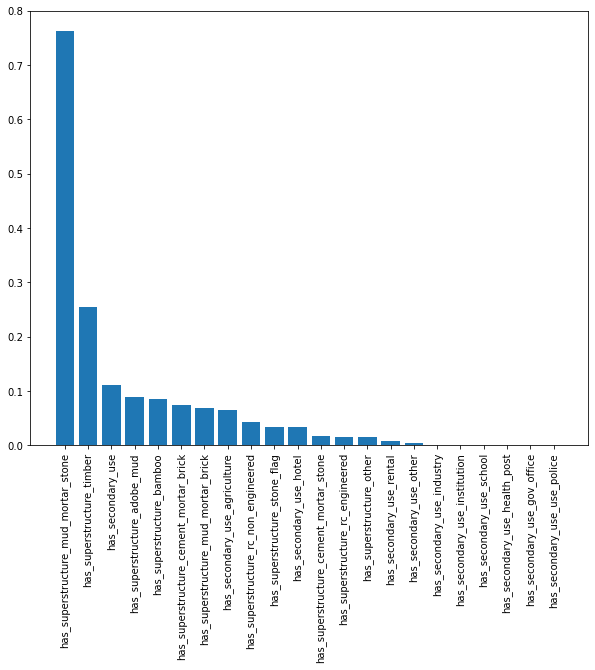

In [55]:
mean_binary_cols = df[binary_cols].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(mean_binary_cols.index, mean_binary_cols.values)
ax.set_xticklabels(list(mean_binary_cols.index), rotation=90);

### Integer Columns

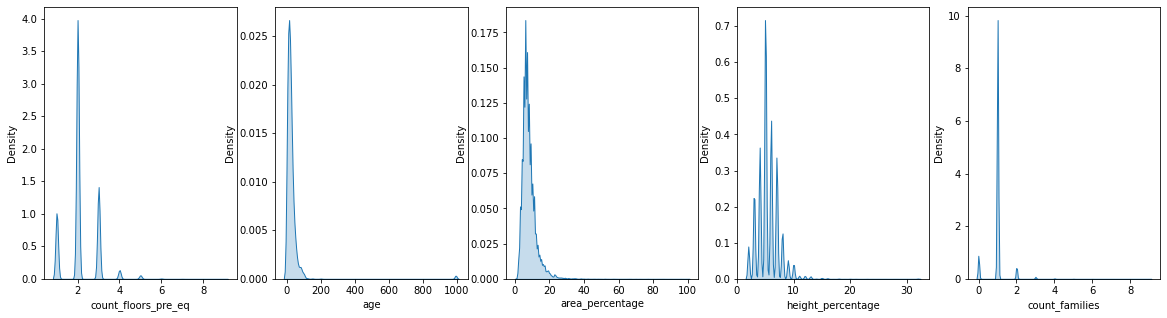

In [75]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, integer_cols):
    sns.kdeplot(df[col], ax=ax, shade=True);

### Geographical Columns

In [76]:
for col in geo_cols:
    print(f'There are {df[col].nunique()} unique values in {col}.')

There are 31 unique values in geo_level_1_id.
There are 1414 unique values in geo_level_2_id.
There are 11595 unique values in geo_level_3_id.
